#### Import required packages

In [3]:
from __future__ import print_function
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
from sklearn.datasets import fetch_mldata
import random
import cntk as C
import cntk.tests.test_utils
from sklearn.preprocessing import OneHotEncoder
import argparse

### parameter

In [4]:
# Training
num_training_samples = 60000 # Number of training samples
batch_size = 64 # Number of mini-batch size
num_epochs = 10 # Number of epochs of data for training
initial_learning_rate = 0.1 # Initial learning rate
train_log_iter = 500 # Number of iteration per training log

# Architecture parameters
feature_dim = (1, 28, 28)    # images are 28 x 28 with 1 channel of color (gray)
num_classes = 10

### Required Objects

In [5]:
# Define the class for mini-batch reader in random fashion.
class Batch_Reader(object):
    def __init__(self, data , label):
        self.data = data
        self.label = label
        self.num_sample = data.shape[0]

    def next_batch(self, batch_size):
        index = random.sample(range(self.num_sample), batch_size)
        return self.data[index,:].astype('float64'),self.label[index,:].astype('float64')

### Loading Data

In [7]:
# Load the data.
mnist = fetch_mldata('MNIST original', transpose_data=True)
X = mnist.data.reshape((-1 , feature_dim[0],feature_dim[1],feature_dim[2]))
y = mnist.target
# Create train & test data.
train_data = X[:num_training_samples,:]
train_label = y[:num_training_samples]
test_data = X[num_training_samples:,:]
test_label = y[num_training_samples:]

# Transform train labels to one-hot style.
enc = OneHotEncoder()
enc.fit(train_label[:,None])
onehotlabels_train = enc.transform(train_label[:,None]).toarray()

# Call and create the ``train_reader`` object.
train_reader = Batch_Reader(train_data, onehotlabels_train)

# Transform test labels to one-hot style.
enc = OneHotEncoder()
enc.fit(test_label[:,None])
onehotlabels_test = enc.transform(test_label[:,None]).toarray()

# Call and create the ``test_reader`` object.
test_reader = Batch_Reader(test_data, onehotlabels_test)

### Network

In [8]:
# Place holders.
input = C.input_variable(feature_dim)
label = C.input_variable(num_classes)

# Creating the architecture
def create_model(features):
    '''
    This function creates the architecture model.
    :param features: The input features.
    :return: The output of the network which its dimentionality is num_classes.
    '''
    with C.layers.default_options(init = C.layers.glorot_uniform(), activation = C.ops.relu):

            # Features are the initial values.
            hidden_out = features

            # Creating some convolutional layers
            hidden_out = C.layers.Convolution2D(filter_shape=(3, 3),
                                       num_filters=16,
                                       strides=(2, 2),
                                       pad=True, name='first_conv')(hidden_out)
            hidden_out = C.layers.Convolution2D(filter_shape=(5, 5),
                                       num_filters=64,
                                       strides=(2, 2),
                                       pad=True, name='second_conv')(hidden_out)

            # Last layer connected to Softmax.
            network_output = C.layers.Dense(num_classes, activation=None, name='classify')(hidden_out)
            return network_output

# Initializing the model with normalized input.
net_out = create_model(input/255.0)

# loss and error calculations.
loss = C.cross_entropy_with_softmax(net_out, label)
label_error = C.classification_error(net_out, label)

# Setup the trainer operator as train_op.
learning_rate_schedule = C.learning_rate_schedule(initial_learning_rate, C.UnitType.minibatch)
learner = C.sgd(net_out.parameters, learning_rate_schedule)
train_op = C.Trainer(net_out, (loss, label_error), [learner])

### Training

In [9]:
# Plot data dictionary.
plotdata = {"iteration":[], "loss":[], "error":[]}

# Initialize the parameters for the trainer
num_iterations = (num_training_samples * num_epochs) / batch_size

# Training loop.
for iter in range(0, int(num_iterations)):

    # Read a mini batch from the training data file
    batch_data, batch_label = train_reader.next_batch(batch_size=batch_size)

    arguments = {input: batch_data, label: batch_label}
    train_op.train_minibatch(arguments=arguments)

    if iter % train_log_iter == 0:

        training_loss = False
        evalaluation_error = False
        training_loss = train_op.previous_minibatch_loss_average
        evalaluation_error = train_op.previous_minibatch_evaluation_average
        print("Minibatch: {0}, Loss: {1:.3f}, Error: {2:.2f}%".format(iter, training_loss, evalaluation_error * 100))

        if training_loss or evalaluation_error:
            plotdata["loss"].append(training_loss)
            plotdata["error"].append(evalaluation_error)
            plotdata["iteration"].append(iter)

/home/sina/anaconda/envs/cntk-py35/lib/python3.5/site-packages/cntk/core.py:351: UserWarning: your data is of type "float64", but your input variable (uid "Input3") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))
/home/sina/anaconda/envs/cntk-py35/lib/python3.5/site-packages/cntk/core.py:351: UserWarning: your data is of type "float64", but your input variable (uid "Input4") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


Minibatch: 0, Loss: 2.296, Error: 89.06%
Minibatch: 500, Loss: 0.118, Error: 3.12%
Minibatch: 1000, Loss: 0.048, Error: 0.00%
Minibatch: 1500, Loss: 0.069, Error: 4.69%
Minibatch: 2000, Loss: 0.066, Error: 3.12%
Minibatch: 2500, Loss: 0.113, Error: 4.69%
Minibatch: 3000, Loss: 0.019, Error: 0.00%
Minibatch: 3500, Loss: 0.008, Error: 0.00%
Minibatch: 4000, Loss: 0.057, Error: 3.12%
Minibatch: 4500, Loss: 0.044, Error: 1.56%
Minibatch: 5000, Loss: 0.024, Error: 0.00%
Minibatch: 5500, Loss: 0.017, Error: 1.56%
Minibatch: 6000, Loss: 0.043, Error: 1.56%
Minibatch: 6500, Loss: 0.027, Error: 0.00%
Minibatch: 7000, Loss: 0.001, Error: 0.00%
Minibatch: 7500, Loss: 0.037, Error: 1.56%
Minibatch: 8000, Loss: 0.005, Error: 0.00%
Minibatch: 8500, Loss: 0.024, Error: 1.56%
Minibatch: 9000, Loss: 0.012, Error: 0.00%


#### Plot

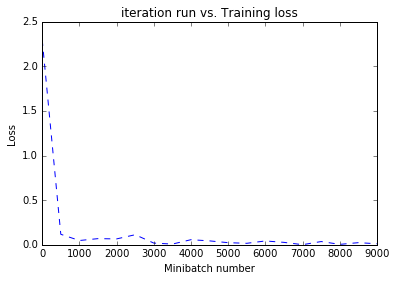

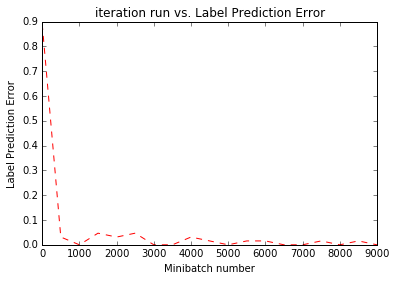

In [10]:
plt.figure()
plt.plot(plotdata["iteration"], plotdata["loss"], 'b--')
plt.xlabel('Minibatch number')
plt.ylabel('Loss')
plt.title('iteration run vs. Training loss')
plt.show()

plt.plot(plotdata["iteration"], plotdata["error"], 'r--')
plt.xlabel('Minibatch number')
plt.ylabel('Label Prediction Error')
plt.title('iteration run vs. Label Prediction Error')
plt.show()

### Test

In [11]:
# Test data.
test_minibatch_size = 256
num_samples = 10000
num_batches_to_test = num_samples // test_minibatch_size
test_error = 0.0

for i in range(num_batches_to_test):

    # Read a mini batch from the test data file
    batch_data, batch_label = test_reader.next_batch(batch_size=test_minibatch_size)

    # Evaluate
    arguments = {input: batch_data, label: batch_label}
    eval_error = train_op.test_minibatch(arguments=arguments)

    # accumulate test error
    test_error = test_error + eval_error

# Calculation of average test error.
average_test_error = test_error*100 / num_batches_to_test

# Average of evaluation errors of all test minibatches
print("Average test error: {0:.2f}%".format(average_test_error))

Average test error: 1.28%


/home/sina/anaconda/envs/cntk-py35/lib/python3.5/site-packages/cntk/core.py:351: UserWarning: your data is of type "float64", but your input variable (uid "Input3") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))
/home/sina/anaconda/envs/cntk-py35/lib/python3.5/site-packages/cntk/core.py:351: UserWarning: your data is of type "float64", but your input variable (uid "Input4") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))
